# Argovis explore vertical structure of ocean fields

This notebook contains some examples and is a work in progress: code will transition from here to other notebooks. Public consumers should focus on our educational notebooks, starting with [Intro to Argovis](https://github.com/argovis/demo_notebooks/blob/main/Intro_to_Argovis.ipynb).

In [1]:
from argovisHelpers import helpers as avh
import datetime, pandas, matplotlib, scipy, numpy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import cartopy.crs as ccrs

import dateutil

from Argovis_tasks_helpers import get_route, interpolate_profiles, grids_to_xarray, xarray_regional_mean, map_lons_lats

API_KEY=''

/Users/dgiglio/opt/miniconda3/envs/argovis_demos/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
# API call showing collections available for each route

#### parameters the user needs to select
# user selects list of collections to use for the plot
collections = ['argo', 'grids/glodap',
              ] # we compare argo profiles with a gridded product

# collections = ['argo', 'grids/rg09',
#               ] # we compare argo profiles with a gridded product

# show list of variables available
for icollection in collections:
    try:
        print(avh.query(icollection+'/vocabulary', options={'parameter': 'data'}, verbose='true',apikey=API_KEY, apiroot=get_route(icollection)) )
    except:
        print(avh.query(icollection+'/vocabulary', verbose='true',apikey=API_KEY, apiroot=get_route(icollection)) )

# define name of variable of interest for each product (first show list of all variables available for each collection)
varname     = ['doxy', 'oxygen']
varname_qc  = [',1', '']
vartitle    = 'Oxygen, umol/kg'

# varname     = ['salinity', 'rg09_salinity']
# varname_qc  = [',1', '']
# vartitle    = 'Salinity, psu'

# varname     = ['temperature', 'rg09_temperature']
# varname_qc  = [',1', '']
# vartitle    = 'Temperature, degC'

# define name of the variable that includes levels for each collection
varname_levels = ['pressure',''] # for the gridded product, the level info is in the metadata, i.e. there is no variable in 'data' (for argo, 'pressure' is within the 'data' instead)

# levels for vertically integrated profiles
interp_levels        = list(range(10,2001))[0::20]

# in this example, we will use the 'box' selection (in the next cell),
# hence we indicate here the bottom/left and top/right vertices... 
# the other option is to search in a 'polygon' and indicate here the polygon
# vertices in a list
box_regions_list     = [
                        [[-179.5,45.5],[-170.5,50.5]],
                        [[-50,45],[-40,50]],
                        ]

regions_tags         = ['Pacific', 'Atlantic']

startDate            = '2021-01-01T00:00:00Z'
endDate              = '2021-12-31T00:00:00Z'

# box_regions_list     = [
#                         [[-78,45],[-10,50]],
#                         [[-180,45],[-127,50]],
#                         ]

https://argovis-api.colorado.edu/argo/vocabulary?parameter=data
['bbp470', 'bbp470_argoqc', 'bbp532', 'bbp532_argoqc', 'bbp700', 'bbp700_2', 'bbp700_2_argoqc', 'bbp700_argoqc', 'bisulfide', 'bisulfide_argoqc', 'cdom', 'cdom_argoqc', 'chla', 'chla_argoqc', 'chla_fluorescence', 'chla_fluorescence_argoqc', 'cndc', 'cndc_argoqc', 'cp660', 'cp660_argoqc', 'down_irradiance380', 'down_irradiance380_argoqc', 'down_irradiance412', 'down_irradiance412_argoqc', 'down_irradiance443', 'down_irradiance443_argoqc', 'down_irradiance490', 'down_irradiance490_argoqc', 'down_irradiance555', 'down_irradiance555_argoqc', 'down_irradiance665', 'down_irradiance665_argoqc', 'down_irradiance670', 'down_irradiance670_argoqc', 'downwelling_par', 'downwelling_par_argoqc', 'doxy', 'doxy2', 'doxy2_argoqc', 'doxy3', 'doxy3_argoqc', 'doxy_argoqc', 'nitrate', 'nitrate_argoqc', 'ph_in_situ_total', 'ph_in_situ_total_argoqc', 'pressure', 'pressure_argoqc', 'salinity', 'salinity_argoqc', 'salinity_sfile', 'salinity_sfile_

Thu Apr  4 13:07:24 MDT 2024
Region [[-179.5, 45.5], [-170.5, 50.5]] , argo collection
https://argovis-api.colorado.edu/argo?box=%5B%5B-179.5%2C+45.5%5D%2C+%5B-170.5%2C+50.5%5D%5D&data=doxy%2C1&startDate=2021-01-01T00%3A00%3A00.000000Z&endDate=2021-12-31T00%3A00%3A00.000000Z
Region [[-179.5, 45.5], [-170.5, 50.5]] , grids/glodap collection
For the glodap product, only the time mean is available
https://argovis-api.colorado.edu/grids/glodap?box=%5B%5B-179.5%2C+45.5%5D%2C+%5B-170.5%2C+50.5%5D%5D&data=oxygen&startDate=0001-01-01T00%3A00%3A00.000000Z&endDate=0001-01-02T00%3A00%3A00.000000Z
https://argovis-api.colorado.edu/grids/meta?id=glodapv2.2016b
Region [[-50, 45], [-40, 50]] , argo collection
https://argovis-api.colorado.edu/argo?box=%5B%5B-50%2C+45%5D%2C+%5B-40%2C+50%5D%5D&data=doxy%2C1&startDate=2021-01-01T00%3A00%3A00.000000Z&endDate=2021-12-31T00%3A00%3A00.000000Z
Region [[-50, 45], [-40, 50]] , grids/glodap collection
For the glodap product, only the time mean is available
https:

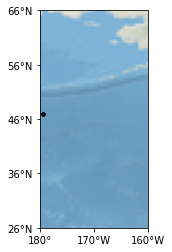

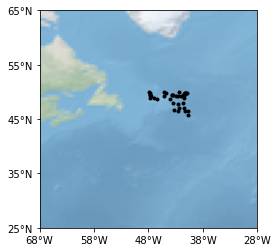

In [3]:
!date

regions_list_data_raw                   = []
regions_list_data_raw_xarray            = []
regions_list_data_vert_interp           = []
regions_list_data_horiz_ave             = []
regions_list_data_horiz_ave_levels      = []
regions_list_data_time                  = []

regions_list                            = []
regions_list_collections                = []
regions_list_tags                       = []
############ Get the data for each of the regions of interest, for each collection
for iiireg,ireg in enumerate(box_regions_list):
    for icol_ind,icollection in enumerate(collections):
        # print and store the region and collection for each item in the output lists
        print('Region '+str(ireg)+' , '+icollection+' collection')
        regions_list.append(ireg)
        regions_list_collections.append(icollection)
        regions_list_tags.append(regions_tags[iiireg])
        ###### get profiles in region using Argovis API (query based on qc if requested above for a collection)
        iparam = {
                'box': ireg,
                'data': varname[icol_ind]+varname_qc[icol_ind]
                } 
                # 'polygon': ireg,
        # the time range does not apply to glodap as only the time mean is available for glodap
        if 'glodap' in icollection:
            print('For the glodap product, only the time mean is available')
        else:
            iparam['startDate'] = startDate
            iparam['endDate']   = endDate
        api_output = avh.query(icollection, options=iparam, verbose='true',apikey=API_KEY, apiroot=get_route(icollection)) 

        ###### store data as is and interpolated
        if api_output: # len(api_output)>0
            ## interpolate profiles (if not from a grid)   
            interpolated_profiles      = []
            timestamps                 = []
            lons                       = []
            lats                       = []
            for i in list(range(0,len(api_output)-1)):
                if len(api_output[i]['data'][0]) > 1:
                    if 'grids' not in icollection:
                        interpolated_profiles.append(interpolate_profiles(profile=api_output[i],levels_varname=varname_levels[icol_ind],levels_new=interp_levels))
                    timestamps.append(dateutil.parser.isoparse(api_output[i]['timestamp'])) 
                    lons.append(api_output[i]['geolocation']['coordinates'][0])
                    lats.append(api_output[i]['geolocation']['coordinates'][1])
            
            if 'grids' not in icollection:
                # shape variable into something appropriate
                data = [x['data'] for x in interpolated_profiles]
                data = [[level[varname[icol_ind]] for level in x] for x in data]
                # store interpolated profiles
                regions_list_data_vert_interp.append(data)
                data = np.transpose(data)
                regions_list_data_horiz_ave.append(np.nanmean(data,1))
                regions_list_data_horiz_ave_levels.append(interp_levels)
                regions_list_data_raw_xarray.append([])
                regions_list_data_raw.append([x['data'] for x in api_output])
                ## quick plot of profiles in region
                map_lons_lats(lons,lats,dx=20,dy=20)
            
            ## store raw profile info
            
            regions_list_data_time.append(timestamps)
            
            
            if 'grids' in icollection:
            
                grids_opt  = {
                            "id": api_output[0]['metadata'][0]
                            }
                grids_meta = avh.query('grids/meta', options=grids_opt, verbose='true',apikey=API_KEY, apiroot=get_route(icollection))

                xar = grids_to_xarray(api_output,grids_meta)
                # store data
                regions_list_data_vert_interp.append([]) # no need to interpolate for grids
                regions_list_data_raw_xarray.append(xar)
                xar_h_ave = xarray_regional_mean(xar)['data'].mean(axis=1).values.flatten()
                regions_list_data_horiz_ave.append(xar_h_ave)
                regions_list_data_horiz_ave_levels.append(grids_meta[0]['levels'][0:len(xar_h_ave)])
                regions_list_data_raw.append([[x['data'][0],grids_meta[0]['levels'][0:len(x['data'][0])]] for x in api_output])
                
                # to see some info about the grid (including the units of the vertical level variable)
                grids_meta
            
!date    

Frozen({'latitude': 6, 'longitude': 10, 'levels': 33, 'timestamp': 1})
Pacific, grids/glodap
Frozen({'latitude': 5, 'longitude': 10, 'levels': 33, 'timestamp': 1})
Atlantic, grids/glodap


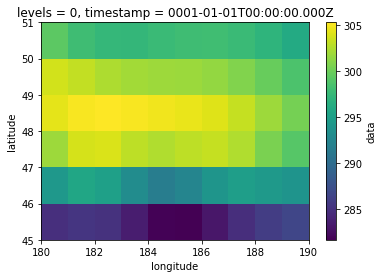

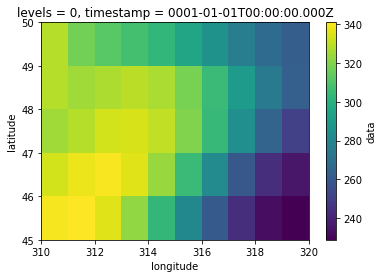

In [4]:
# plot the map for one timestep/level for each of the gridded products
for i,iaxr in enumerate(regions_list_data_raw_xarray):
    if iaxr:
        print(iaxr.sizes)
        print(regions_list_tags[i]+', '+regions_list_collections[i])
        plt.figure()
        iaxr['data'][:,:,0,0].plot()

In [5]:
len(regions_list_data_horiz_ave)

4

In [6]:
cols = ['k','r','b','m']

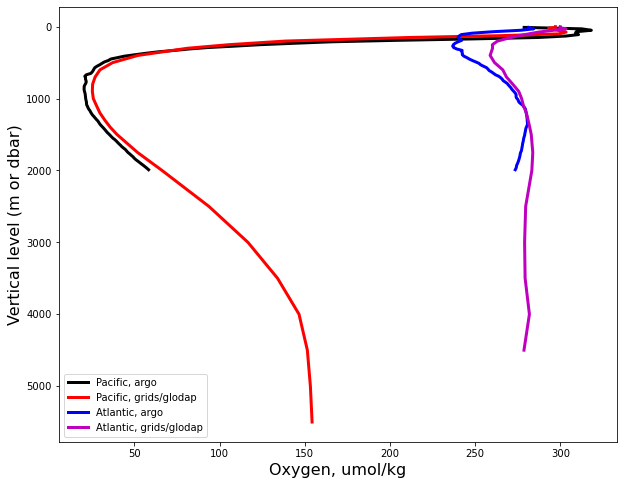

In [7]:
# plot the horizontal average for (vertically) interpolated profiles and for the gridded product
plt.figure(figsize=(10,8))
for i,idata in enumerate(regions_list_data_horiz_ave):
    plt.plot(idata,regions_list_data_horiz_ave_levels[i],color=cols[i],linewidth=3)
plt.gca().invert_yaxis()
plt.ylabel('Vertical level (m or dbar)',size=16)
plt.xlabel(vartitle,size=16)
plt.legend([a_+', '+b_ for a_, b_ in zip(regions_list_tags,regions_list_collections)])


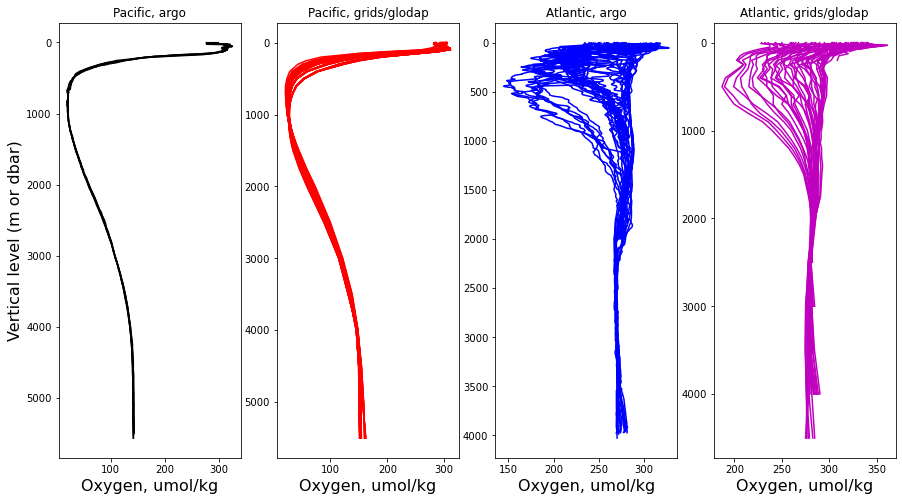

In [8]:
# let's look at all the profiles that were vertically interpolated (except for the gridded products) to then compute the horizontal average above
plt.figure(figsize=(15,8))
for i,idata in enumerate(regions_list_data_raw):
    plt.subplot(1,len(regions_list_data_horiz_ave),i+1)    
    for iidata in idata:
        plt.plot(iidata[0],iidata[1],color=cols[i])
    plt.gca().invert_yaxis()
    if i==0:
        plt.ylabel('Vertical level (m or dbar)',size=16)
    plt.title(regions_list_tags[i]+', '+regions_list_collections[i])
    plt.xlabel(vartitle,size=16)
    

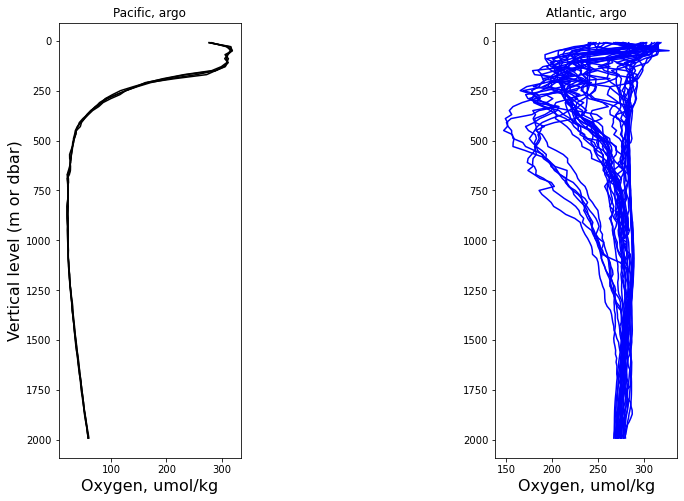

In [9]:
# let's look at all the vertically interpolated profiles that were used to compute the horizontal average above
plt.figure(figsize=(15,8))
for i,idata in enumerate(regions_list_data_vert_interp):
    if idata:
        plt.subplot(1,len(regions_list_data_horiz_ave),i+1)    
        for iidata in idata:
            plt.plot(iidata,regions_list_data_horiz_ave_levels[i],color=cols[i])
        plt.gca().invert_yaxis()
        if i==0:
            plt.ylabel('Vertical level (m or dbar)',size=16)
        plt.title(regions_list_tags[i]+', '+regions_list_collections[i])
        plt.xlabel(vartitle,size=16)
    

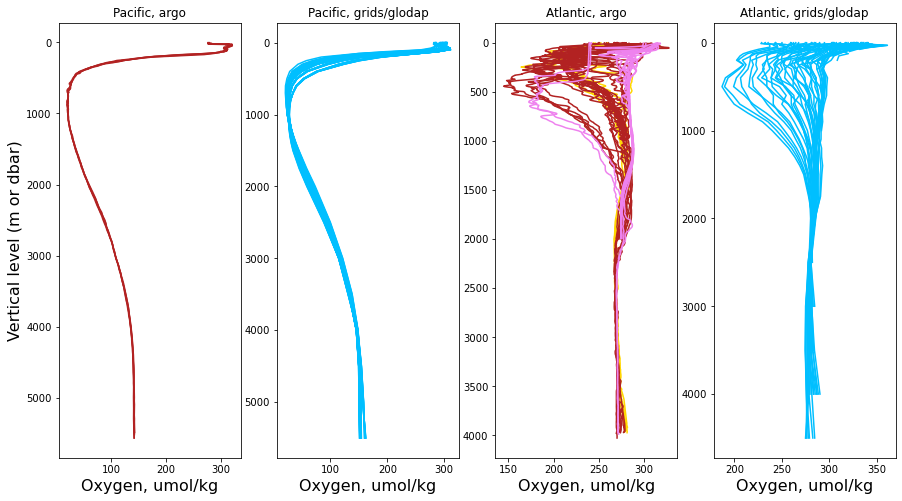

In [20]:
#https://sites.google.com/view/paztronomer/blog/basic/python-colors
cols_months = ['deepskyblue', 'violet', 'firebrick', 'gold']
months      = [[12, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11]]
# for each product, plot the raw profiles color coded by month of the year
plt.figure(figsize=(15,8))
for i,idata in enumerate(regions_list_data_raw):
    itime = regions_list_data_time[i]
    
    plt.subplot(1,len(regions_list_data_horiz_ave),i+1)    
    for ii,iidata in enumerate(idata):
        for imm,mm in enumerate(months):
            if ii<=len(itime)-1 and itime[ii].month in mm:
                plt.plot(iidata[0],iidata[1],color=cols_months[imm])
    plt.gca().invert_yaxis()
    if i==0:
        plt.ylabel('Vertical level (m or dbar)',size=16)
    plt.title(regions_list_tags[i]+', '+regions_list_collections[i])
    plt.xlabel(vartitle,size=16)


In [ ]:
# bin in time? platform? woceline?

In [21]:
# #regions_list_data_time_month = [x.month for y in regions_list_data_time for x in y]


# # plot raw profiles that go into the average colorcoded by month of year
# for i,idata in enumerate(regions_list_data_raw):
#     itime = regions_list_data_time[i]
#     for ii,iidata in enumerate(idata):
        
#         if ii<=len(itime)-1 and itime[ii].month in [6, 7, 8]:
#             plt.plot(iidata[0],iidata[1],c='k',marker='.')
            
#         # check for oxygen data
#         if ('doxy' in varname) and sum(np.array(iidata[0])<0) != 0:
#             check_data
# #plt.ylim([0, 20])
# plt.gca().invert_yaxis()        
# plt.ylabel('Vertical level')
# plt.xlabel(vartitle)